In [1]:
__file__ = 'A1.ipynb'
import sys
import pathlib
sys.path.append(str(pathlib.Path(__file__).absolute().parent.parent)+"/FP4_lib")
import functions as f
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from uncertainties import unumpy as up
from uncertainties import ufloat
import scipy.constants as const
import scipy.fft as fft
import lmfit

In [2]:
with open('Data/Aufg_6.2.txt','r') as tf:
    data = np.genfromtxt(tf).T
with open('Res/cp-cal_res.txt','r') as tf:
    cal = np.genfromtxt(tf).T
for i in range(len(data[1])):
    data[0][i]-= 616800

data = f.channel_to_pos(data,cal)

In [3]:
data[1] = data[1]*100
yerr = 0.035339825186025027*np.abs(data[1])
print(np.mean(data[2]))

0.0018895178825636732


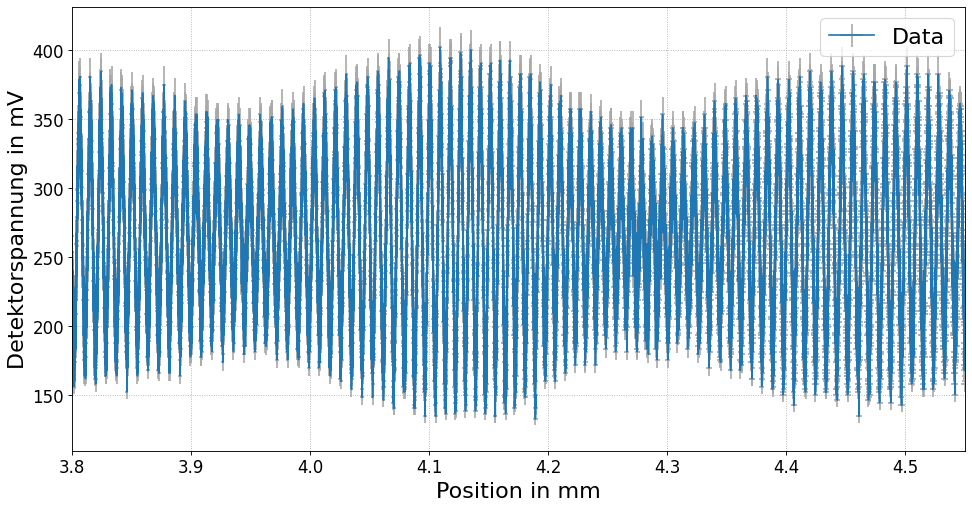

In [4]:
f.figsize(2)
plt.errorbar(data[0],data[1],yerr=yerr,xerr=data[2],label = 'Data',ecolor='darkgray')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
f.form([3.8,4.55],xlabel='Position in mm',ylabel='Detektorspannung in mV',name='Res/A6_interferogramm.pdf')

Wavelength: 3.4796973315671394e-06 m


/tmp/ipykernel_9767/922266909.py:20: RuntimeWarning: divide by zero encountered in divide
  freqs = 1/freqs


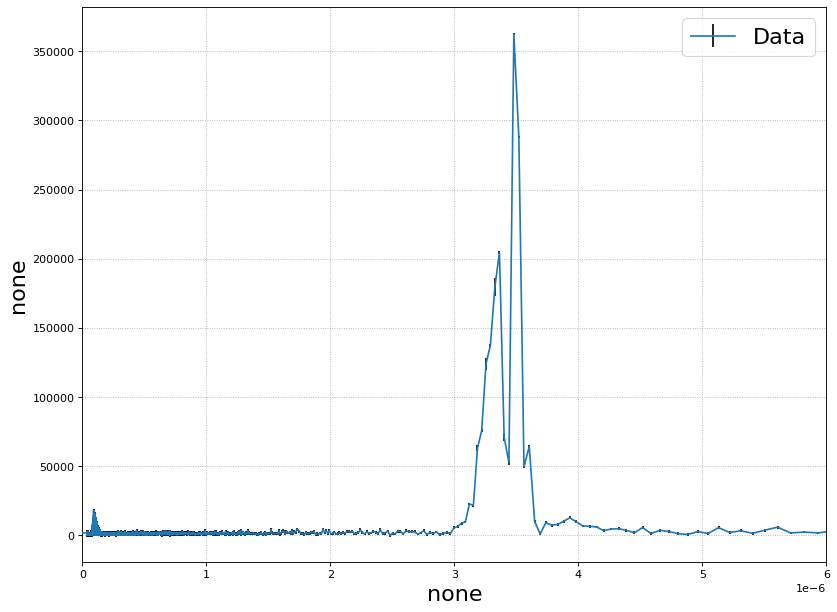

In [5]:
freq_scale = 2/5.127868608985219*1e-3

intensity = data[1]
position  = data[0]*freq_scale


intensity -= np.mean(intensity)


freqs = np.fft.fftfreq(len(intensity), d=((np.mean(np.diff(position)))))
fft_int = np.fft.fft(intensity)
fft_err = np.fft.fft(yerr).clip(10*100)

peak_idx = np.argmax(np.abs(fft_int))
peak_freq = freqs[peak_idx]


print(f"Wavelength: {1/peak_freq} m")

freqs = 1/freqs

f.figsize(1)

plt.errorbar(freqs, np.abs(fft_int),yerr=np.abs(fft_err),ecolor='k',zorder=10,label='Data')
plt.xlim(0,0.6e-5)



#plt.vlines(3.6271e-06,0,3600,colors="r")
#plt.vlines(3.4007e-06,0,3600,colors="b")

f.form()

In [6]:
dat = [freqs, np.abs(fft_int),np.abs(fft_err)]

sorted_indices = sorted(range(len(dat[0])), key=lambda k: dat[0][k])

dat_sorted = [[dat[0][i], dat[1][i],dat[2][i]] for  i in sorted_indices]

dat_sorted = np.array(dat_sorted).T

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 13
    # variables        = 3
    chi-square         = 2913.63871
    reduced chi-square = 291.363871
    Akaike info crit   = 76.3587123
    Bayesian info crit = 78.0535604
    R-squared          = 0.99999995
[[Variables]]
    amplitude:  0.03879202 +/- 0.00387934 (10.00%) (init = 0.03224966)
    center:     3.3365e-06 +/- 9.7778e-09 (0.29%) (init = 3.309059e-06)
    sigma:      8.3388e-08 +/- 9.8615e-09 (11.83%) (init = 5.425335e-08)
    fwhm:       1.9636e-07 +/- 2.3222e-08 (11.83%) == '2.3548200*sigma'
    height:     185587.795 +/- 14678.5117 (7.91%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.7496
    C(center, sigma)     = +0.4956
    C(amplitude, center) = +0.4729
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function eva

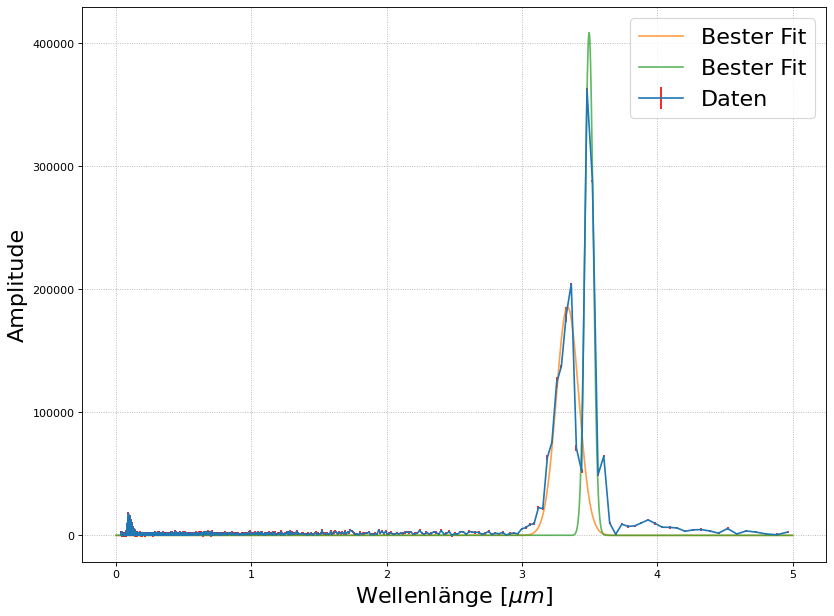

In [7]:
von,bis = f.pos(dat_sorted[0],0),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.3e-5),f.pos(dat_sorted[0],0.345e-5)#0.3425e-5)
von2,bis2 = f.pos(dat_sorted[0],0.341e-5),f.pos(dat_sorted[0],0.37e-5)


xscale = 1e6



res1 = f.gausfit(dat_sorted[1,von1:bis1],dat_sorted[0,von1:bis1],dat_sorted[2,von1:bis1])
#res1.plot()
print(res1.fit_report())

res2 = f.gausfit(dat_sorted[1,von2:bis2],dat_sorted[0,von2:bis2],dat_sorted[2,von2:bis2])
#res2.plot()
print(res2.fit_report())


plt.show()
f.figsize(1)

plt.errorbar(dat_sorted[0,von:bis]*xscale,dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],ecolor = 'r',label='Daten')
plt.plot(np.arange(0,5e-6,1e-9)*xscale,res1.eval(x=np.arange(0,5e-6,1e-9)),alpha=0.75,label='Bester Fit')#,color='y')
plt.plot(np.arange(0,5e-6,1e-9)*xscale,res2.eval(x=np.arange(0,5e-6,1e-9)),alpha=0.75,label='Bester Fit')#,color='y')

f.form(xlabel=f'Wellenlänge [$\mu m$]',ylabel='Amplitude',name='Res/A6_fftfit.pdf')


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 275
    # data points      = 16
    # variables        = 6
    chi-square         = 9288.29500
    reduced chi-square = 928.829500
    Akaike info crit   = 113.822745
    Bayesian info crit = 118.458277
    R-squared          = 0.99999994
[[Variables]]
    g1_amplitude:  0.03651571 +/- 0.00665503 (18.23%) (init = 0.01)
    g1_center:     3.3213e-06 +/- 1.4001e-08 (0.42%) (init = 3.3e-06)
    g1_sigma:      7.9532e-08 +/- 1.7963e-08 (22.59%) (init = 8e-08)
    g2_amplitude:  0.02766635 +/- 0.00437372 (15.81%) (init = 0.01)
    g2_center:     3.4973e-06 +/- 3.0356e-09 (0.09%) (init = 3.5e-06)
    g2_sigma:      2.6826e-08 +/- 6.1921e-09 (23.08%) (init = 8e-08)
    g1_fwhm:       1.8728e-07 +/- 4.2300e-08 (22.59%) == '2.3548200*g1_sigma'
    g1_height:     183167.579 +/- 27358.8636 (14.94%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma

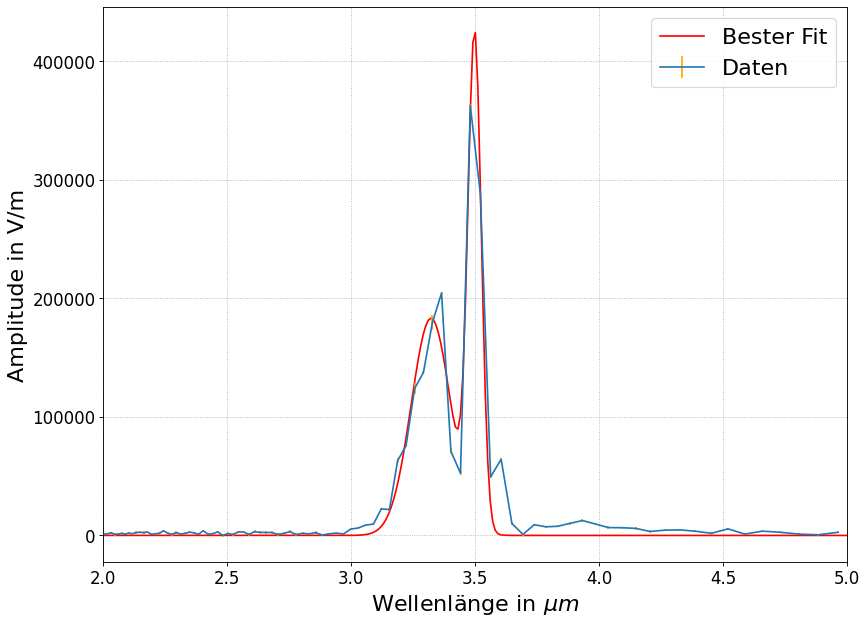

In [8]:
von,bis = f.pos(dat_sorted[0],0.2e-5),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.31e-5),f.pos(dat_sorted[0],0.37e-5)


model_gaus3 = lmfit.models.GaussianModel(prefix='g1_')+lmfit.models.GaussianModel(prefix='g2_')
    
pars_gaus3=model_gaus3.make_params()
pars_gaus3['g1_amplitude'].set(0.01)
pars_gaus3['g1_center'].set(3.3e-6,min=3.1e-6,max=3.3213e-6)
pars_gaus3['g1_sigma'].set(8e-08)

pars_gaus3['g2_amplitude'].set(0.01)
pars_gaus3['g2_center'].set(3.5e-6,min=3.41e-6,max=3.6e-6)
pars_gaus3['g2_sigma'].set(8e-08)

res = model_gaus3.fit(dat_sorted[1,von1:bis1],x=dat_sorted[0,von1:bis1],weights=1/dat_sorted[2,von1:bis1].clip(1),params=pars_gaus3,nan_policy='propagate')


#plt.errorbar(dat_sorted[0,von:bis],dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],ecolor = 'k')
#out_gaus.plot()
print(res.fit_report())

f.figsize(1)

plt.errorbar(dat_sorted[0,von:bis]*xscale,dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],fmt='-',ecolor = 'orange',label='Daten',zorder=10)
plt.plot(np.arange(0,7e-6,1e-8)*xscale,res.eval(x=np.arange(0,7e-6,1e-8)),color='r',label='Bester Fit')
plt.xlim(0.2e-5*xscale,0.5e-5*xscale)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
f.form(xlabel=f'Wellenlänge in $\mu m$',ylabel='Amplitude in V/m',name='Res/A6_fftfit.pdf')